# Analysis of time series data

In [70]:
# general packeges
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Linear regression
from sklearn.linear_model import LinearRegression

# Gradient boosting
import xgboost as xgb

# Time series cross validation
from sklearn.model_selection import TimeSeriesSplit

# assesment metric
from sklearn.metrics import mean_squared_error

## DATA

In [76]:
# load data from github
url = 'https://raw.githubusercontent.com/Fdvanleeuwen/Energy-Price-Forecasting/main/Data/PJME_hourly.csv'
df = pd.read_csv(url)
df = df.set_index('Datetime') # set the index as the Datetime column
df.index = pd.to_datetime(df.index) # change type of data of index to datetime

In [77]:
# inspect the data
df.head(5)

# There is the outcome variable PJME_MW and only time as a predictor

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


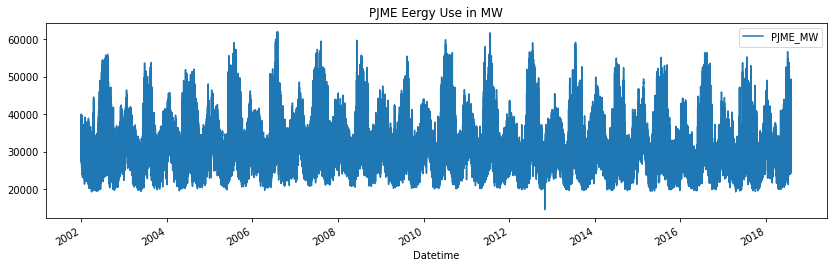

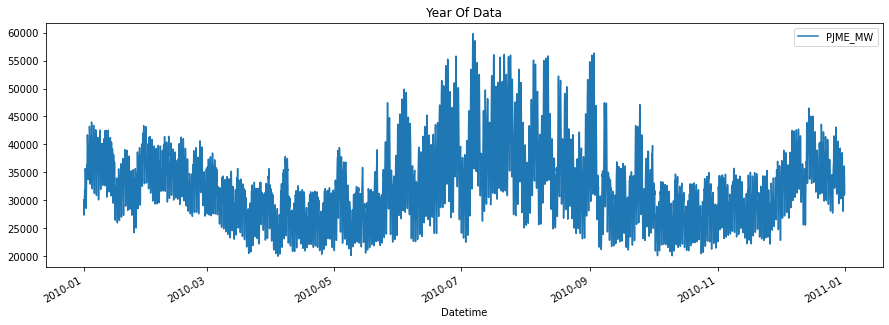

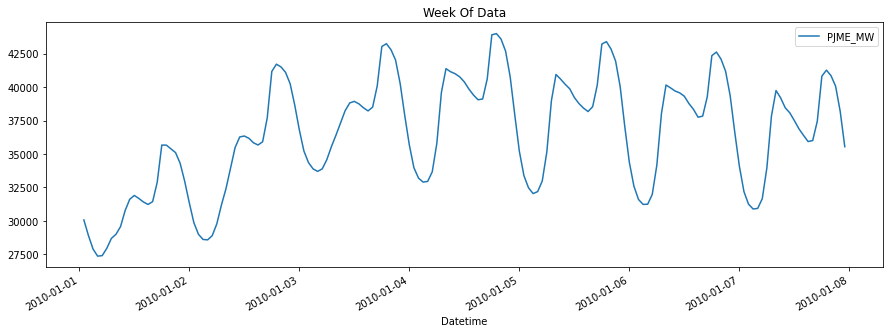

In [78]:
# plot the full data
df.plot(figsize = (14,4), title = 'PJME Eergy Use in MW')

# plot a year worth to see the variablity
df.loc[(df.index > '01-01-2010') & (df.index < '01-01-2011')] \
    .plot(figsize=(15, 5), title='Year Of Data')
plt.show()

# plot a weeks worth to see the variablity
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

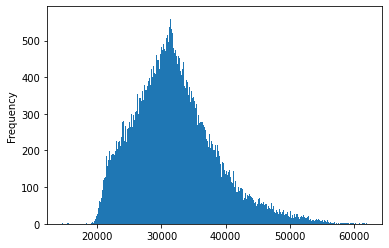

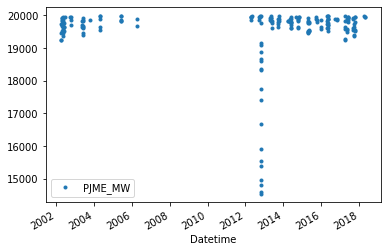

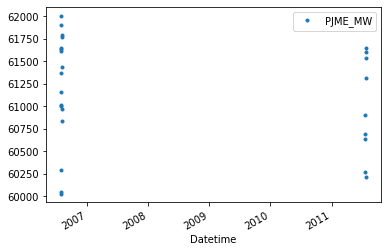

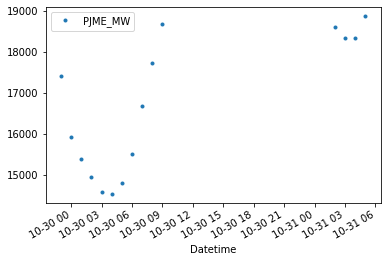

In [84]:
# check for outliers
df['PJME_MW'].plot(kind ='hist', bins = 1000)

# most values in 20-60k range

df.query('PJME_MW < 20000').plot(style = '.')
df.query('PJME_MW > 60000').plot(style = '.')

# it seems that there are extremes lower than 19000
df.query('PJME_MW < 19000').plot(style = '.')

df = df.query('PJME_MW > 19000').copy()

## Train/Test set

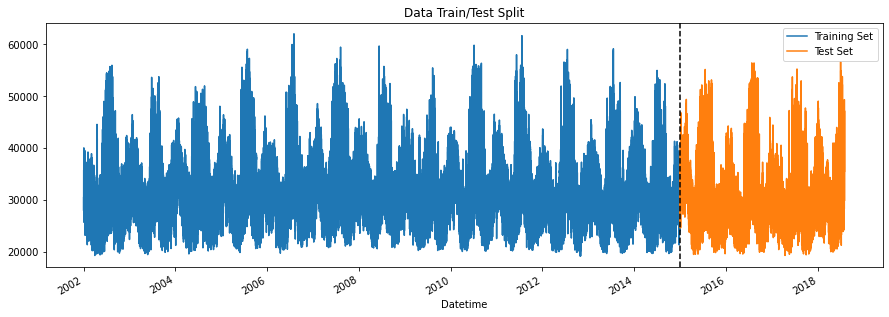

In [85]:
# training data is approx 80% of data, test is 20%
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

# plot when the devide in the data is
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Feature creation

In [86]:
# create a funciton that makes features based

def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [87]:
df = create_features(df)

# check out the new predictors
df.head(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


## Visualize our Feature / Target Relationship


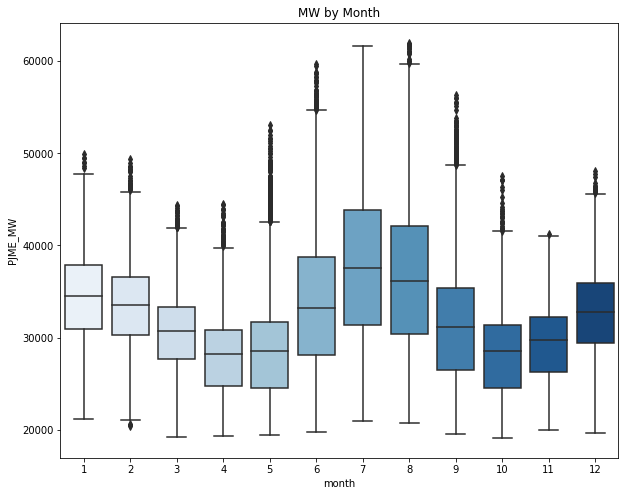

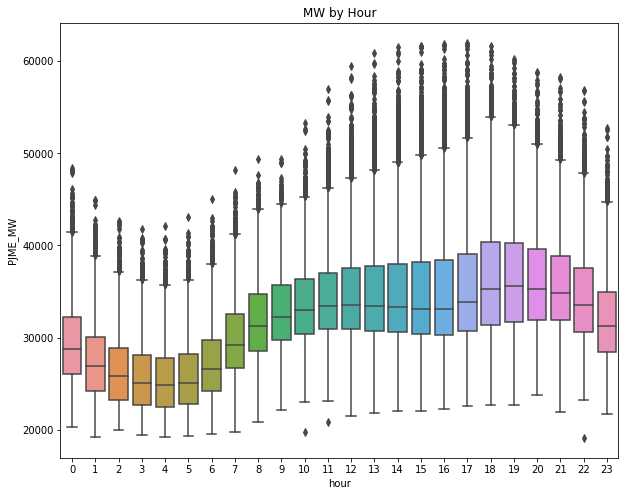

In [88]:
# Variation per month
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Variation per day
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

## Simple Models

In [89]:
# create seperate data set for the x and y values
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### Linear regression

In [90]:
# fit model
m1 = LinearRegression()
m1.fit(X_train, y_train)

# predict
test['prediction_LR']  = m1.predict(X_test)

### Gradient Boosting

In [91]:
# model with 1000 trees, it stops if there is no increase after 50 trees
# base_score and booster are set to defaults
# objective is linear regression
# max depth is set to 3 to prevent overfitting
# learning rate set to 0.01 to prevent overfitting

m2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
m2.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[10:35:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[10:35:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32606.70508	validation_1-rmse:31657.14648


/Users/florian/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12582.83008	validation_1-rmse:11744.91309
[200]	validation_0-rmse:5834.90918	validation_1-rmse:5365.04785
[300]	validation_0-rmse:3921.07397	validation_1-rmse:4025.10083
[400]	validation_0-rmse:3444.71606	validation_1-rmse:3857.71924
[500]	validation_0-rmse:3287.44409	validation_1-rmse:3809.04883
[600]	validation_0-rmse:3205.97900	validation_1-rmse:3772.75439
[700]	validation_0-rmse:3150.65894	validation_1-rmse:3752.56250
[800]	validation_0-rmse:3109.79565	validation_1-rmse:3734.33276
[900]	validation_0-rmse:3080.21533	validation_1-rmse:3724.17358
[999]	validation_0-rmse:3052.40869	validation_1-rmse:3722.77100


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [92]:
test['prediction_GB'] = m2.predict(X_test)

### Compare the models

In [93]:
# check how well the models run
test[['prediction_GB','prediction_LR']].tail(5)
df = df.merge(test[['prediction_GB','prediction_LR']], how='left', left_index=True, right_index=True)

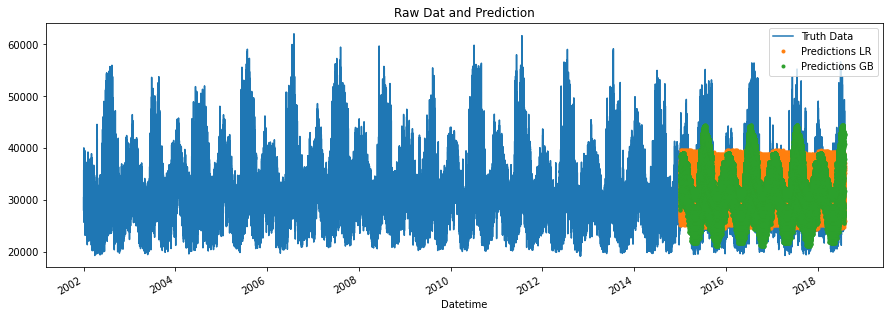

In [94]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction_LR'].plot(ax=ax, style='.')
df['prediction_GB'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions LR', 'Predictions GB'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [68]:
score_LR = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction_LR']))
score_GB = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction_GB']))
print(f'RMSE Score on Test set for LR: {score_LR:0.2f}')
print(f'RMSE Score on Test set for GB: {score_GB:0.2f}')

RMSE Score on Test set for LR: 5683.70
RMSE Score on Test set for GB: 3722.60


## Advanced models

### Time series cross validation

In [95]:
# Data is split up in 5 datasets 
# test_size is equal to the time we want to predict in the future
# gap is the gap between the training and test sets 
# we will run 5 models all with 1 year of sequential validation data

m3 = TimeSeriesSplit(n_splits = 5, test_size=24*365*1, gap = 24)
df = df.sort_index()

### Lag features

In [102]:
# create a lag 1/2/3 (year) feature
def add_lags123(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [103]:
df = add_lags123(df)

In [105]:
# the values for the first year will be na's up to 3 years with the lag 3
df.tail(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_GB,prediction_LR,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42696.648438,35668.487622,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,42533.257812,36130.529183,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,40801.511719,36592.570745,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,37932.246094,37054.612306,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,31749.861328,25814.446268,33539.0,32094.0,31695.0


In [107]:
# store the objects
fold = 0
preds = []
scores = []

# loop 5 times over the algorithm
for train_idx, val_idx in m3.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[10:50:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32732.30664	validation_1-rmse:31956.18750


/Users/florian/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12532.09668	validation_1-rmse:11907.30957
[200]	validation_0-rmse:5741.74707	validation_1-rmse:5353.56250
[300]	validation_0-rmse:3867.58081	validation_1-rmse:3890.84033
[400]	validation_0-rmse:3430.05591	validation_1-rmse:3753.97046
[500]	validation_0-rmse:3313.44751	validation_1-rmse:3767.99683
[600]	validation_0-rmse:3257.11108	validation_1-rmse:3781.85620
[700]	validation_0-rmse:3217.38623	validation_1-rmse:3791.59668
[800]	validation_0-rmse:3182.33960	validation_1-rmse:3799.20581
[900]	validation_0-rmse:3152.73535	validation_1-rmse:3789.42969
[999]	validation_0-rmse:3120.67822	validation_1-rmse:3782.09253
[10:50:58] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:58] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/

/Users/florian/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12513.15625	validation_1-rmse:12224.63379
[200]	validation_0-rmse:5754.32324	validation_1-rmse:5658.62353
[300]	validation_0-rmse:3902.51172	validation_1-rmse:3935.24414
[400]	validation_0-rmse:3475.66260	validation_1-rmse:3601.97949
[500]	validation_0-rmse:3354.59473	validation_1-rmse:3533.03394
[600]	validation_0-rmse:3298.02026	validation_1-rmse:3496.44995
[700]	validation_0-rmse:3258.22070	validation_1-rmse:3470.85864
[800]	validation_0-rmse:3223.87354	validation_1-rmse:3449.40308
[900]	validation_0-rmse:3197.08496	validation_1-rmse:3441.58252
[999]	validation_0-rmse:3169.63794	validation_1-rmse:3432.69507
[10:51:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/

/Users/florian/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12498.41211	validation_1-rmse:11130.58301
[200]	validation_0-rmse:5748.66699	validation_1-rmse:4806.84375
[300]	validation_0-rmse:3913.33496	validation_1-rmse:3543.68042
[400]	validation_0-rmse:3490.60083	validation_1-rmse:3489.14648
[500]	validation_0-rmse:3375.66138	validation_1-rmse:3548.40503
[600]	validation_0-rmse:3317.00659	validation_1-rmse:3594.07202
[700]	validation_0-rmse:3274.64819	validation_1-rmse:3625.31641
[800]	validation_0-rmse:3243.15747	validation_1-rmse:3659.89770
[900]	validation_0-rmse:3216.79761	validation_1-rmse:3695.42554
[999]	validation_0-rmse:3191.54004	validation_1-rmse:3715.28833
[10:51:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/

/Users/florian/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12461.64746	validation_1-rmse:12017.21387
[200]	validation_0-rmse:5736.46191	validation_1-rmse:5792.72119
[300]	validation_0-rmse:3913.95019	validation_1-rmse:4383.20068
[400]	validation_0-rmse:3495.38257	validation_1-rmse:4171.92920
[500]	validation_0-rmse:3380.41211	validation_1-rmse:4123.12988
[600]	validation_0-rmse:3321.61231	validation_1-rmse:4110.08643
[700]	validation_0-rmse:3282.18262	validation_1-rmse:4093.73975
[800]	validation_0-rmse:3249.60742	validation_1-rmse:4091.92676
[900]	validation_0-rmse:3220.98926	validation_1-rmse:4086.00806
[999]	validation_0-rmse:3195.27661	validation_1-rmse:4065.53052
[10:51:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/

/Users/florian/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12445.02734	validation_1-rmse:11959.38672
[200]	validation_0-rmse:5750.29883	validation_1-rmse:5617.38623
[300]	validation_0-rmse:3950.17065	validation_1-rmse:4150.43115
[400]	validation_0-rmse:3538.55884	validation_1-rmse:3995.73144
[500]	validation_0-rmse:3427.91260	validation_1-rmse:4026.43359
[600]	validation_0-rmse:3371.26733	validation_1-rmse:4050.99145
[700]	validation_0-rmse:3333.89575	validation_1-rmse:4052.71240
[800]	validation_0-rmse:3303.19507	validation_1-rmse:4048.33179
[900]	validation_0-rmse:3275.00879	validation_1-rmse:4044.00366
[999]	validation_0-rmse:3252.78906	validation_1-rmse:4031.25464


In [108]:
# check the scores 
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3805.3721
Fold scores:[3782.0923619296236, 3432.6947233055266, 3715.2885243911232, 4065.5311560120344, 4031.2537502094615]


### Predict in the feature

In [109]:
# The model is retrained on all of the training data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]


# n_est is lowered to 500 since that is around the value in cross val 
# where the models started to overfit
m4 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
m4.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[10:56:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.51172


/Users/florian/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12426.29492
[200]	validation_0-rmse:5751.87744
[300]	validation_0-rmse:3970.81714
[400]	validation_0-rmse:3570.29370
[499]	validation_0-rmse:3455.03052


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [112]:
# Create a future dataframe
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [119]:
# first day is the last day of the real data
# predicton period is 1 year
# add freq to match the real dataset which is in hours
future = pd.date_range('2018-08-03', '2019-08-03', freq = '1h')
future_df = pd.DataFrame(index = future)

# create indicators for a merge of datasets
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

# add features and lag values
df_and_future = create_features(df_and_future)
df_and_future = add_lags123(df_and_future)

In [120]:
df_and_future

/Users/florian/opt/miniconda3/lib/python3.9/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/florian/opt/miniconda3/lib/python3.9/site-packages/IPython/core/formatters.py:343: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_GB,prediction_LR,lag1,lag2,lag3,isFuturee,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,NaN,False,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,NaN,False,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,NaN,False,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,NaN,False,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-02 20:00:00,NaN,20,4,3,8,2019,214,2,31,NaN,NaN,NaN,43606.0,40513.0,NaN,True
2019-08-02 21:00:00,NaN,21,4,3,8,2019,214,2,31,NaN,NaN,NaN,41863.0,39840.0,NaN,True
2019-08-02 22:00:00,NaN,22,4,3,8,2019,214,2,31,NaN,NaN,NaN,40005.0,38664.0,NaN,True
2019-08-02 23:00:00,NaN,23,4,3,8,2019,214,2,31,NaN,NaN,NaN,37174.0,36125.0,NaN,True


In [121]:
# df for only prediction dates
future_w_features = df_and_future.query('isFuture').copy()

In [122]:
future_w_features['pred'] = m4.predict(future_w_features[FEATURES])

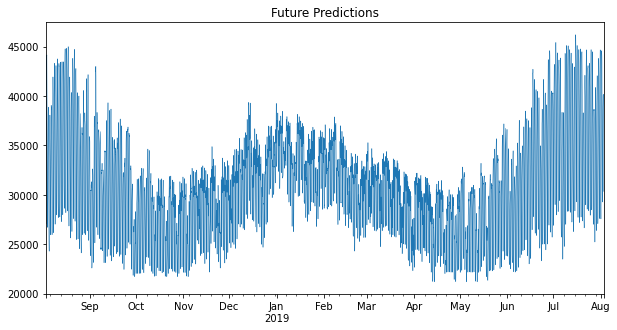

In [130]:
future_w_features['pred'].plot(figsize=(10,5),
                               lw = 0.5,
                               title = 'Future Predictions')
plt.show()

## Save models

In [134]:
# XGboost models
m2.save_model('m2.json')
m4.save_model('m4.json')